In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# reading the time series (pd.Series format)
series = pd.read_csv('all_weather.csv')

tseries = series['t_out'] + 5
# you can simulate some data with:
# tseries = pd.Series(np.random.random(100))

rhseries = series['rh_out']

In [52]:
def C_F(T):
    return (T*9/5) + 32

In [53]:
# Heat index calculation
heat_i = []
c1 = -42.379
c2 = 2.04901523
c3 = 10.14333127
c4 = -0.22475541
c5 = -6.83783e-03
c6 = -5.481717e-02
c7 = 1.22874e-03
c8 = 8.5282e-04
c9 = -1.99e-06

for i in range(len(series)):
    if C_F(tseries[i]) < 80:
        index = 0.5*(C_F(tseries[i]) + 61 + (C_F(tseries[i]) - 68)*1.2 + (rhseries[i]*0.094))
        heat_i.append(index)
        # print(index)
    else:
        index = c1 + c2*C_F(tseries[i]) + c3*rhseries[i] + c4*C_F(tseries[i])*rhseries[i] + c5*C_F(tseries[i])**2 + c6*rhseries[i]**2 + c7*C_F(tseries[i])**2*rhseries[i] + c8*C_F(tseries[i])*rhseries[i]**2 + c9*C_F(tseries[i])**2*rhseries[i]**2
        heat_i.append(index)

series['heat_index'] = heat_i
tseries = series['heat_index']

In [65]:
# using 3 lags -- the no. of observation we look back to model the next value of the series
N_LAGS = 7
# Constructing a set of observations based on past recent values (lags)
tseries_df = pd.concat([tseries.shift(i) for i in range(N_LAGS, -1, -1)], axis=1)
# Assigning column names and dropping na's
tseries_df.columns = ['t-' + str(i) for i in list(reversed(range(N_LAGS)))] + ['t+1']
tseries_df = tseries_df.dropna().reset_index(drop=True)

# the target variable is the column 't+1' representing the next value of the series
y = tseries_df[['t-2', 't-1', 't-0', 't+1']]
# Removing the target to create the predictor variables
X = tseries_df[['t-6', 't-5', 't-4', 't-3']]

# basic train/test split -- you may want a more robust cross-validation approach
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

# setting the threshold to the 95th percentile
thr = 85

# transforming the numeric target to a binary one 
y_train_binary = np.sum((y_train >= thr), axis = 1).astype(int)
y_test_binary = np.sum((y_test >= thr), axis = 1).astype(int)

# training a probabilistic classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train_binary)

# predicting exceedance probability
exceedance_prob_clf = classifier.predict_proba(X_train)[:, 1]

/Users/aoyuzou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0, 0.5, 'Temperature (°F)')

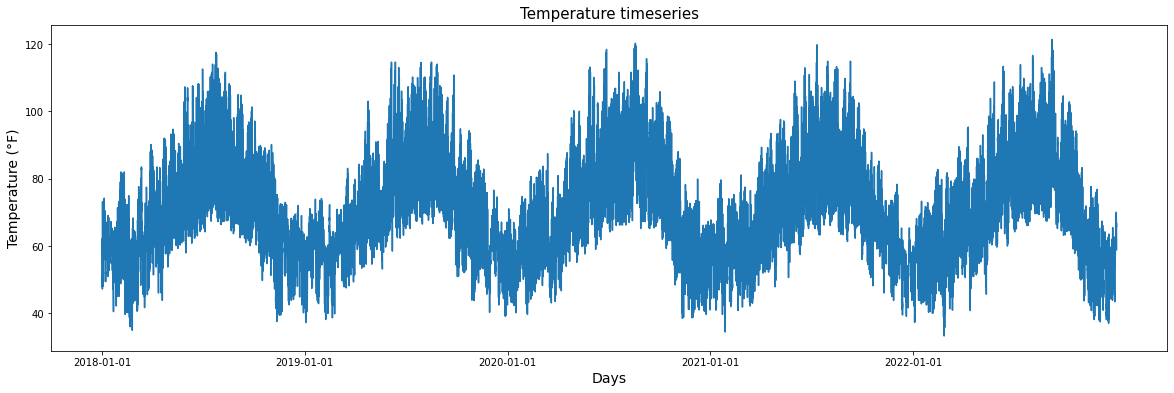

In [66]:
plt.figure(figsize=[20, 6])
plt.plot(tseries)
plt.title('Temperature timeseries', fontsize = 15)
plt.xticks([0, 365*24, 365*2*24, 365*3*24, 365*4*24], ['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01'])
plt.xlabel('Days', fontsize = 14)
plt.ylabel('Temperature (°F)', fontsize = 14)

In [67]:
# # Using the RF as ensemble of trees
# from sklearn.ensemble import RandomForestRegressor

# # Training the model
# forecasting_ensemble = RandomForestRegressor()
# # Here we use the numerical target
# ## which represents the next value of the time series
# forecasting_ensemble.fit(X_train, y_train)

# # Retrieving the predictions from the trees.
# per_tree_pred = [tree.predict(X_test) for tree in forecasting_ensemble.estimators_]
# per_tree_df = pd.DataFrame(per_tree_pred).T

# # Computing the ratio of trees which predict a value above the threshold
# exceedance_prob_fe = per_tree_df.apply(lambda x: np.mean(x > thr), axis=1).values

In [68]:

# from sklearn.metrics import brier_score_loss, roc_auc_score

# roc_auc_score(y_true=y_test_binary, y_score=exceedance_prob_fe)
# roc_auc_score(y_true=y_test_binary, y_score=exceedance_prob_clf)

# brier_score_loss(y_true=y_test_binary, y_prob=exceedance_prob_fe)
# brier_score_loss(y_true=y_test_binary, y_prob=exceedance_prob_clf)

Text(0, 0.5, 'Probability')

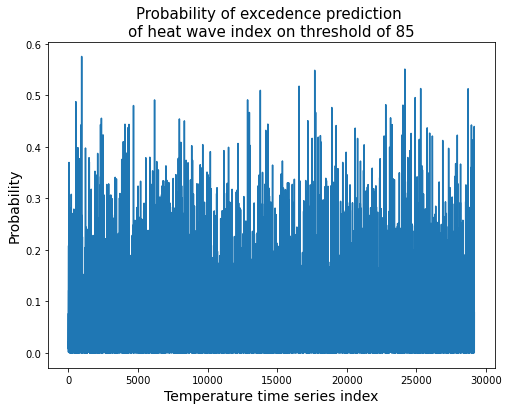

In [69]:
plt.figure(figsize=[8, 6])
plt.plot(exceedance_prob_clf)
plt.title("Probability of excedence prediction \nof heat wave index on threshold of {}".format(thr), fontsize = 15)
plt.xlabel("Temperature time series index", fontsize = 14)
plt.ylabel("Probability", fontsize = 14)

Text(0.5, 1.0, 'Distribution density plot of excedence probability')

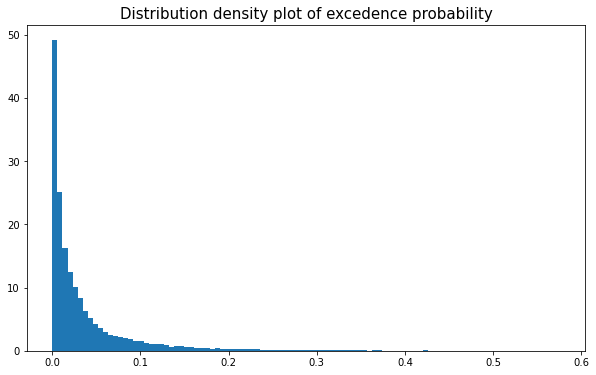

In [73]:
plt.figure(figsize=[10, 6])
plt.hist(exceedance_prob_clf, bins=100, density=True)
plt.title('Distribution density plot of excedence probability', fontsize = 15)